In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import os

from main import DCTrader, Backtest
from trainer import GATrainer, PSOTrainer

In [3]:
from strategies import St1, St2, St3, St4, St5, St6, St7, St8

ticker = 'AAPL'

thresholds = [0.00098, 0.0022, 0.0048, 0.0072, 0.0098, 0.0122, 0.0155, 0.017, 0.02, 0.0255]
strategies = [St1, St2, St3, St4, St5, St6, St7, St8]

# Modo entrenamiento (precomputa estados)
trader = DCTrader(
    ticker=ticker,
    thresholds=thresholds,
    strategies=strategies,
    is_train=True,
    start_date='2020-01-01',
    end_date='2024-01-01'
)

print(f"Trader creado para {ticker}")
print(f"Thresholds: {thresholds}")
print(f"Datos cargados: {len(trader.prices)} días")

AAPL: 1006 loaded days | 2020-01-02 to 2023-12-29
Trader creado para AAPL
Thresholds: [0.00098, 0.0022, 0.0048, 0.0072, 0.0098, 0.0122, 0.0155, 0.017, 0.02, 0.0255]
Datos cargados: 1006 días


In [4]:
trader = DCTrader(ticker='AAPL', thresholds=[0.001, 0.003, 0.005, 0.01, 0.02], 
                  strategies=[St1, St2, St3, St4, St5, St6, St7, St8],
                  is_train=True)

backtester = Backtest(trader)

AAPL: 2554 loaded days | 2015-10-19 to 2025-12-12


In [9]:
print(backtester.run_single_strategy(strategy_idx=0, threshold_idx=2))  # St1 con theta medio
print(backtester.run_single_strategy(strategy_idx=0, threshold_idx=3))

{'RoR': np.int64(0), 'STD': np.float64(0.0), 'SR': 0, 'VaR': 0, 'ToR': 0.0, 'returns': [0]}
{'RoR': np.int64(0), 'STD': np.float64(0.0), 'SR': 0, 'VaR': 0, 'ToR': 0.0, 'returns': [0]}


In [8]:
trader.fit()

Iniciando entrenamiento GA | Poblacion: 150 | Generaciones: 50
Numero total de pesos a optimizar: 70
  Generacion   1 | Mejor fitness: 0.0000
  Generacion  10 | Mejor fitness: 0.0000


KeyboardInterrupt: 

In [ ]:
trader_test = DCTrader(
    ticker='AAPL',
    thresholds=thresholds,
    strategies=strategies,
    is_train=False,                 # No precomputar estados nuevos
    start_date='2024-01-01',        # Periodo de test
    end_date='2025-12-01'
)

trader_test.load_model()            # Cargar pesos entrenados

AAPL: 481 loaded days | 2024-01-02 to 2025-12-01


In [ ]:
DCTrader.weights

AttributeError: type object 'DCTrader' has no attribute 'weights'

In [ ]:
# Celda 5: Backtest del ensemble y métricas básicas
backtester = Backtest(trader_test)
metrics_ensemble = backtester.run_ensemble()
print("Métricas Ensemble:")
metrics_ensemble

Métricas Ensemble:


{'RoR': np.float64(0.5432742801776556),
 'STD': np.float64(0.0),
 'SR': 0,
 'VaR': np.float64(0.5432742801776557),
 'ToR': 0.002079002079002079,
 'returns': [np.float64(0.5432742801776557)]}

In [ ]:
# Celda 6: Comparar varias estrategias (ensemble, buy&hold y algunas single)
comparacion = backtester.compare_metrics([
    'MSTGAM',
    'buy_hold',
    (2, 0),     # St3 con theta=0.01
    (3, 1),     # St4 con theta=0.02
    (0, 2),     # St1 con theta=0.015
])
comparacion

,RoR,STD,SR,VaR,ToR
MSTGAM,0.543274,0.0,0.0,0.543274,0.002079
Buy & Hold,0.531719,0.0,0.0,0.000000,0.004158
St3 (theta_0),0.563126,0.0,0.0,0.000000,0.002079
St4 (theta_1),0.543274,0.0,0.0,0.000000,0.002079
St1 (theta_2),0.000000,0.0,0.0,0.000000,0.000000


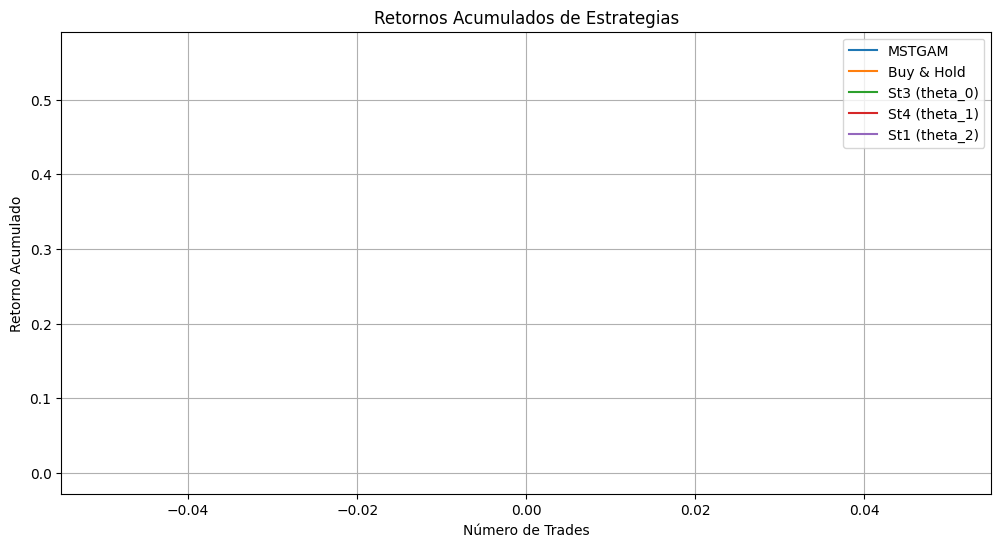

In [ ]:
comparacion = backtester.plot_returns([
    'MSTGAM',
    'buy_hold',
    (2, 0),     # St3 con theta=0.01
    (3, 1),     # St4 con theta=0.02
    (0, 2),     # St1 con theta=0.015
])
comparacion

In [ ]:
# Celda 8: (Opcional) Probar una predicción single en un punto concreto
t_test = 10  # día de prueba
p_test = trader_test.prices.iloc[t_test]

action_single = trader_test.predict_single(
    t_current=t_test,
    p_current=p_test,
    strategy_idx=2,      # St3 (índice 2)
    threshold_idx=0
)

print(f"Día {t_test} | Precio: {p_test:.2f}")
print(f"Recomendación St3 (theta=0.01): {['Hold', 'Buy', 'Sell'][action_single]}")

Día 10 | Precio: 180.97
Recomendación St3 (theta=0.01): Hold


In [ ]:
# Celda 9: (Opcional) Backtest rápido de una estrategia single
metrics_st3 = backtester.run_single_strategy(strategy_idx=2, threshold_idx=0)
print("Métricas St3 (theta=0.01):")
metrics_st3

Métricas St3 (theta=0.01):


{'RoR': np.float64(0.5694243576366909),
 'STD': np.float64(0.0),
 'SR': 0,
 'VaR': 0,
 'ToR': 0.002079002079002079,
 'returns': [np.float64(0.5694243576366909)]}